In [1]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("/scratch/user/weiwu/435-group-proj/Sample_Sort/cali/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 279/279 [00:10<00:00, 25.46it/s]


In [3]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.004 MPI_Comm_dup
0.000 MPI_Finalize
0.000 MPI_Finalized
0.000 MPI_Initialized
0.024 main
├─ 0.008 comm
│  ├─ 0.008 comm_large
│  │  ├─ 0.002 MPI_Gatherv
│  │  └─ 0.006 MPI_Scatter
│  └─ 0.000 comm_small
│     └─ 0.000 MPI_Gather
├─ 0.015 comp
│  ├─ 0.015 comp_large
│  │  └─ 0.003 comm
│  │     ├─ 0.002 comm_large
│  │     │  ├─ 0.001 MPI_Alltoall
│  │     │  ├─ 0.001 MPI_Alltoallv
│  │     │  └─ 0.000 MPI_Gather
│  │     └─ 0.001 comm_small
│  │        └─ 0.001 MPI_Bcast
│  └─ 0.000 comp_small
├─ 0.003 correctness_check
└─ 0.004 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.02 indices: {'profile': 10199925})
█ 0.02 - 0.02
█ 0.02 - 0.02
█ 0.01 - 0.02
█ 0.01 - 0.01
█ 0.00 - 0.01
█ 0.00 - 0.00

name User code    ◀  Only in left graph    ▶  Only in right graph



In [4]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_type")
tk.metadata_column_to_perfdata("input_size")

# tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_type", "input_size"]).sort_index()
tk.dataframe = tk.dataframe.reset_index()

In [24]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
input_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]
input_types = ["random", "sorted", "reverse_sorted", "1%perturbed"]

# processes proportional to input sizes
processes_weak = [2, 8, 512, 1024]
input_sizes_weak = [2**16, 2**18, 2**24, 2**26]

In [40]:
# Change font size for all plots
plt.rcParams.update({"font.size": 12})

# strong scaling plot function
def plot_strong_scaling(tk, node_name):
    for node in tk.graph.traverse():
        if (node.frame['name'] == node_name):
            for input_size in input_sizes:
                fig, ax = plt.subplots(figsize=(10, 6))
                for input_type in input_types:
                    data = tk.dataframe[(tk.dataframe["input_type"] == input_type) & (tk.dataframe["input_size"] == input_size) & (tk.dataframe['node'] == node)]
                    data = data.sort_values(by="num_procs")
                    ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label=input_type)
                ax.set_title(f'Strong Scaling for Input Size {input_size} for node {node_name}')
                ax.set_xlabel('Number of Processors')
                ax.set_ylabel('Average Time per Rank (seconds)')
                ax.legend()
                plt.show()
# strong scaling speedup plot function
def plot_strong_scaling_speedup(tk, node_name):
    for node in tk.graph.traverse():
        if (node.frame['name'] == node_name):
            for input_type in input_types:
                fig, ax = plt.subplots(figsize=(10, 6))
                for input_size in input_sizes:
                    # speedup calculated by execution time of 1 process / execution time of p processes
                    # can just double the time for 2 process count
                    t1 = tk.dataframe[
                        (tk.dataframe["input_type"] == input_type) &
                        (tk.dataframe["input_size"] == input_size) &
                        (tk.dataframe["node"] == node) &
                        (tk.dataframe["num_procs"] == 2)
                    ]["Avg time/rank"]*2
                    data = tk.dataframe[(tk.dataframe["input_type"] == input_type) & (tk.dataframe["input_size"] == input_size) & (tk.dataframe['node'] == node)]
                    data = data.sort_values(by="num_procs")
                    speedups = [t1/p for p in data["Avg time/rank"]]
                    ax.plot(data["num_procs"], speedups, marker='o', label=input_size)
                ax.set_title(f'Strong Scaling Speedup for Input Type {input_type} for node {node_name}')
                ax.set_xlabel('Number of Processors')
                ax.set_ylabel('Speedup')
                ax.legend()
                plt.show()

# weak scaling plot function
def plot_weak_scaling(tk, node_name):
    for node in tk.graph.traverse():
        if (node.frame['name'] == node_name):
            for input_type in input_types:
                fig, ax = plt.subplots(figsize=(10,6))
                x_vals = []
                y_vals = []
                for input_size, process in zip(input_sizes_weak, processes_weak):
                    data = tk.dataframe[
                        (tk.dataframe["input_type"] == input_type) & 
                        (tk.dataframe["input_size"] == input_size) & 
                        (tk.dataframe['node'] == node) & 
                        (tk.dataframe["num_procs"] == process)
                    ]
                    y_vals.append(data["Avg time/rank"])
                    x_vals.append(process)
                ax.plot(x_vals, y_vals, marker='o', label=input_type)
                ax.set_title(f'Weak Scaling for Input Type {input_type} for node {node_name}')
                ax.set_xlabel('Number of Processors')
                ax.set_ylabel('Average Time per Rank (seconds)')
                plt.show()

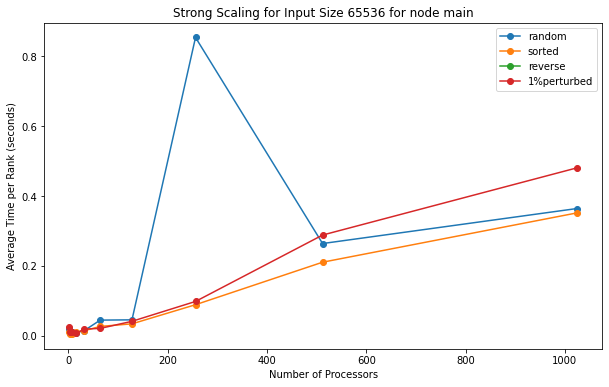

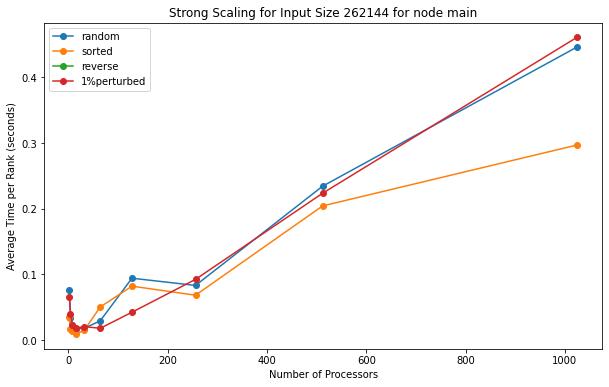

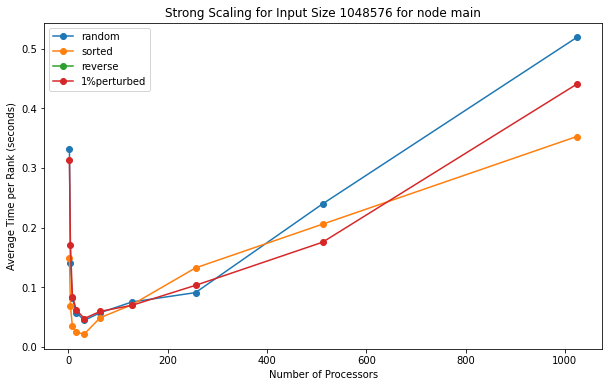

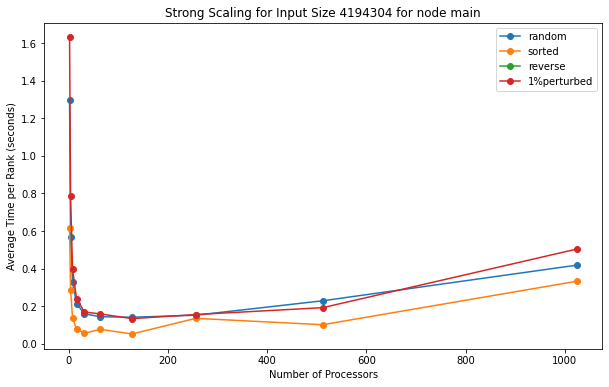

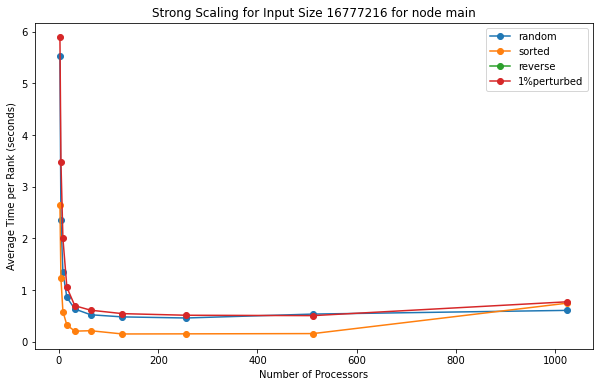

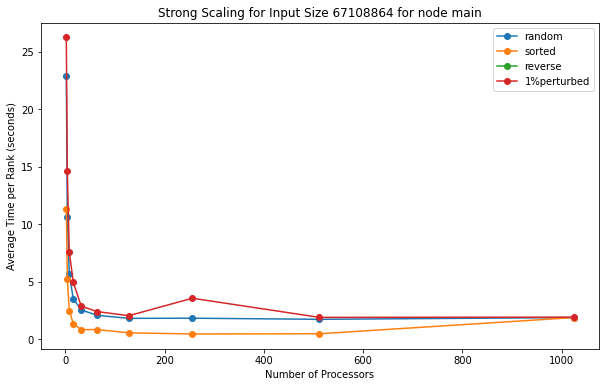

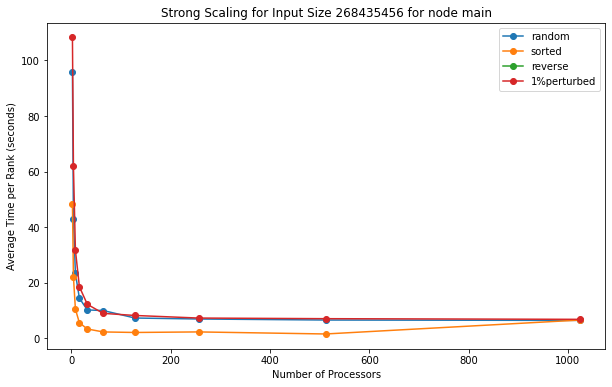

In [12]:
# strong scaling for each input size with lines for each input type for main
plot_strong_scaling(tk, 'main')

# strong scaling for each input size with lines for each input type comp
plot_strong_scaling(tk, 'comp_large')

# strong scaling for each input size with lines for each input type comm
plot_strong_scaling(tk, 'comm')

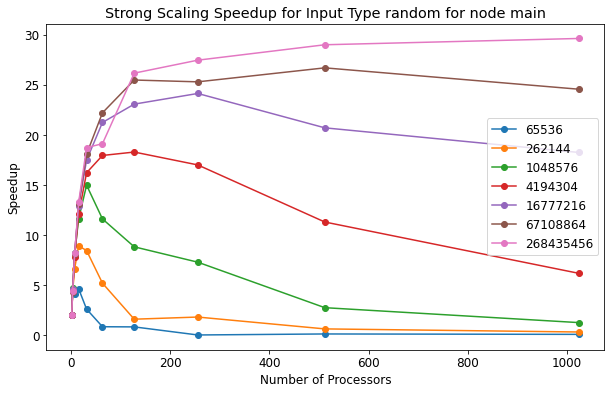

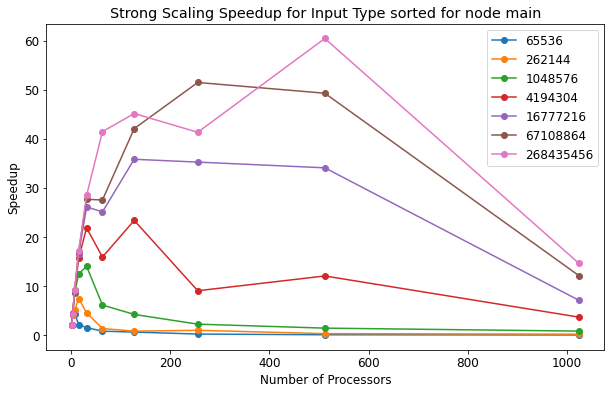

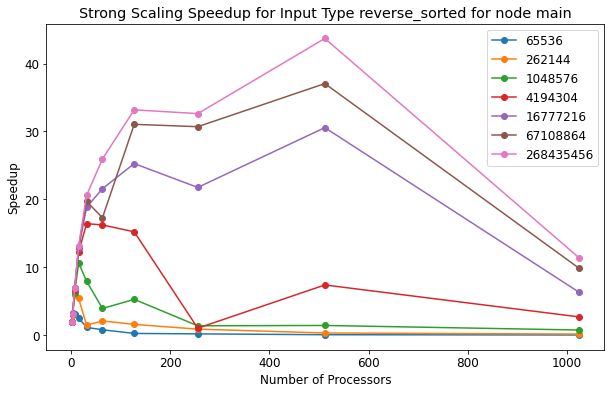

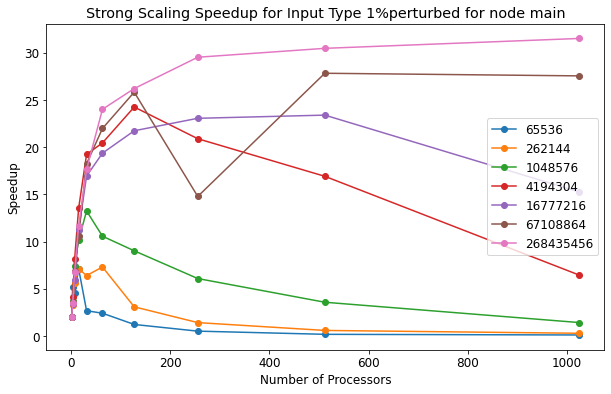

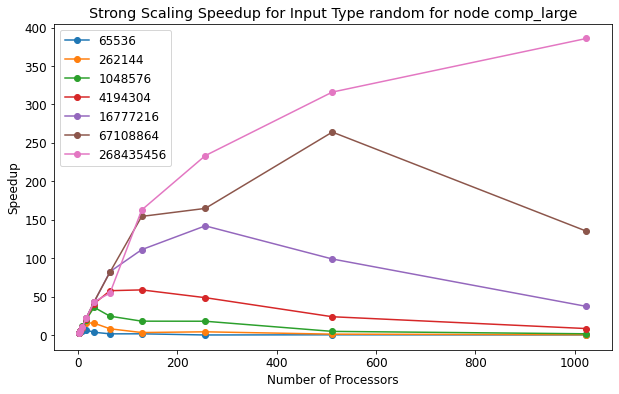

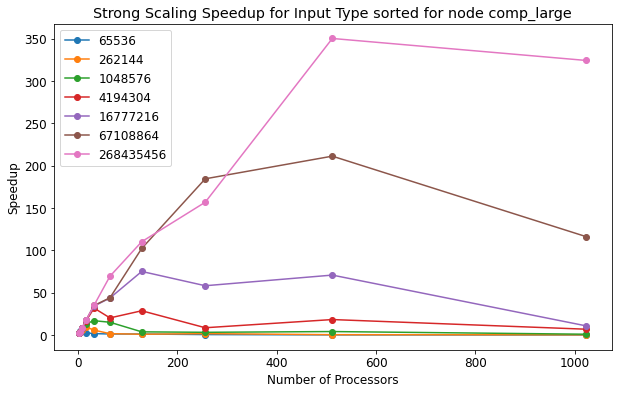

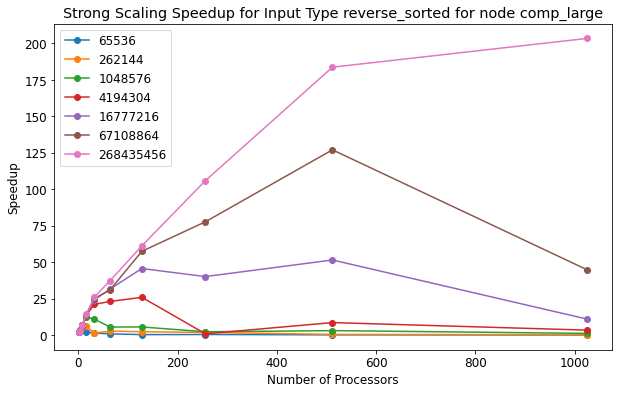

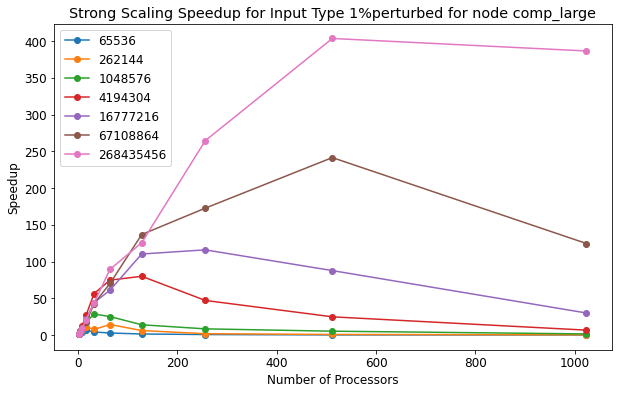

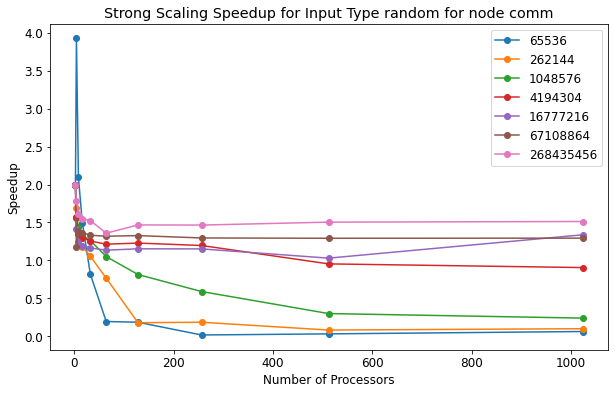

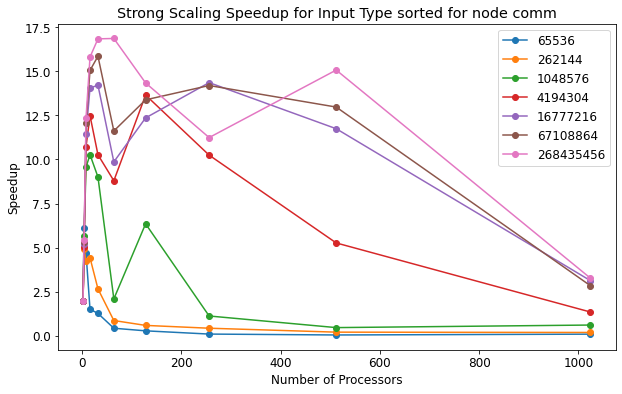

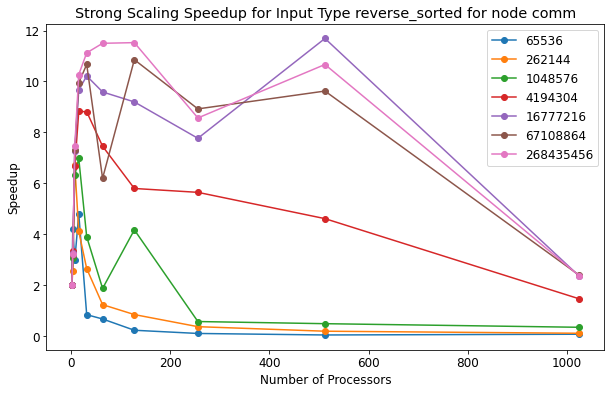

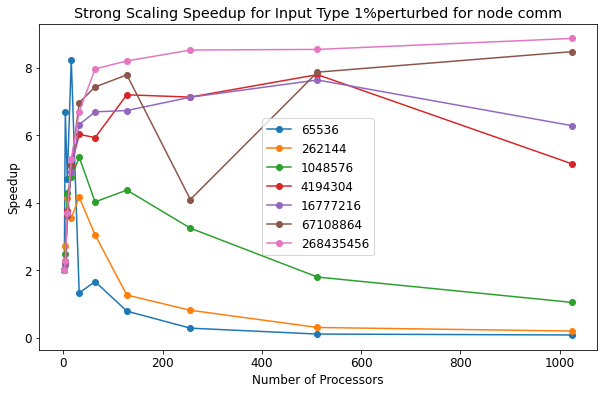

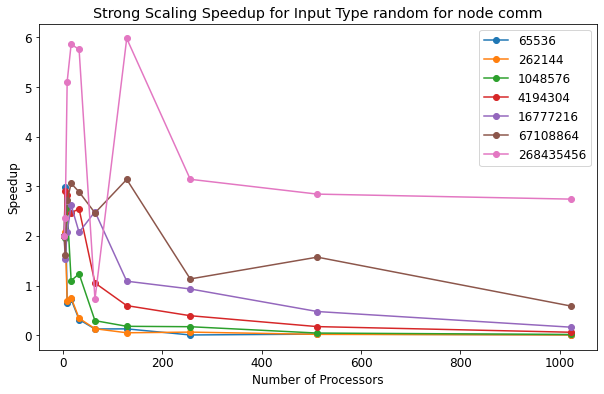

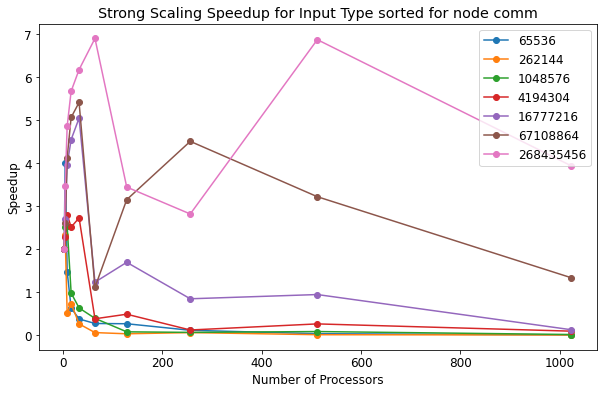

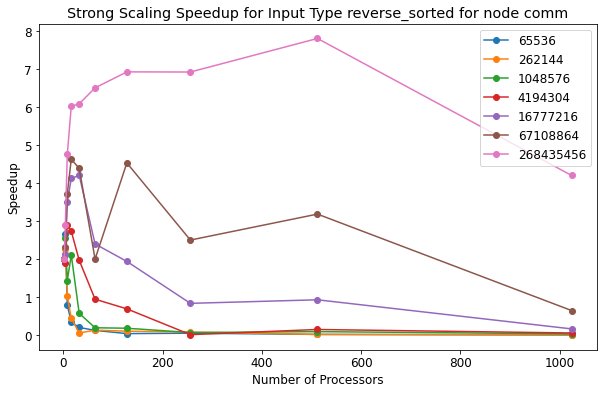

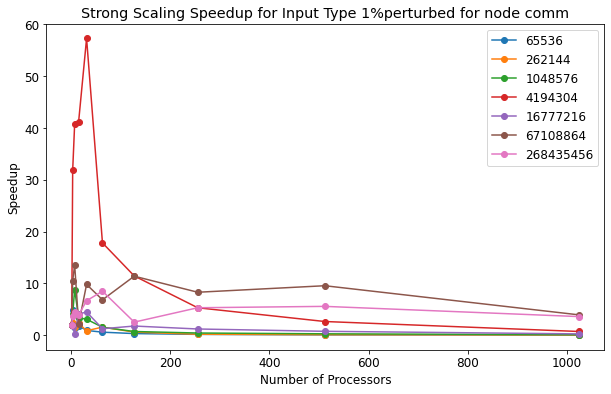

In [42]:
# strong scaling speedup for each input type for main
plot_strong_scaling_speedup(tk, 'main')
# strong scaling speedup for each input type for comp_large
plot_strong_scaling_speedup(tk, 'comp_large')
# strong scaling speedup for each input type for comm
plot_strong_scaling_speedup(tk, 'comm')

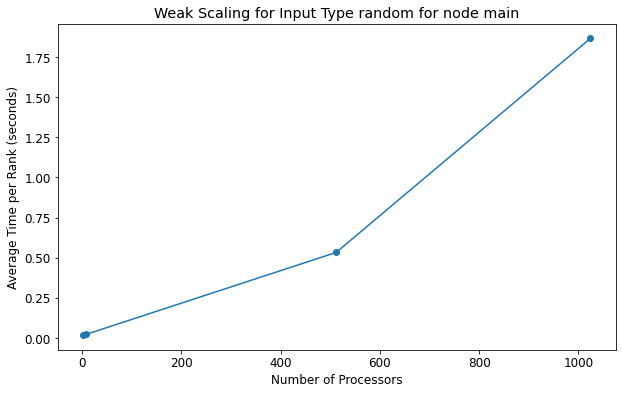

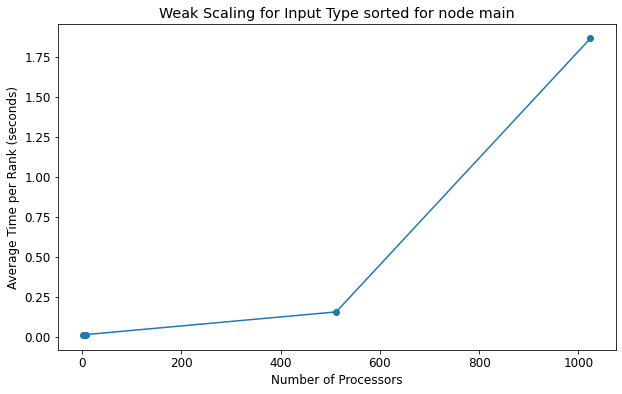

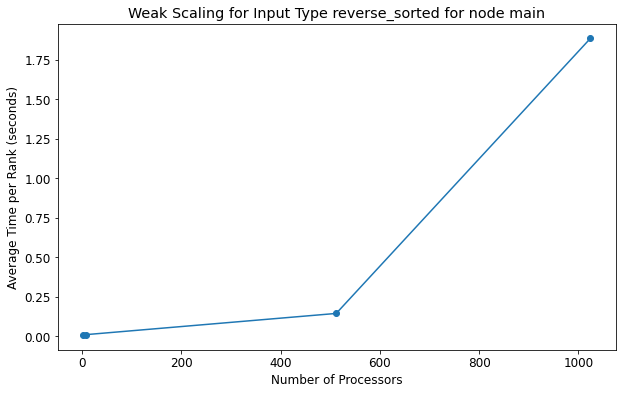

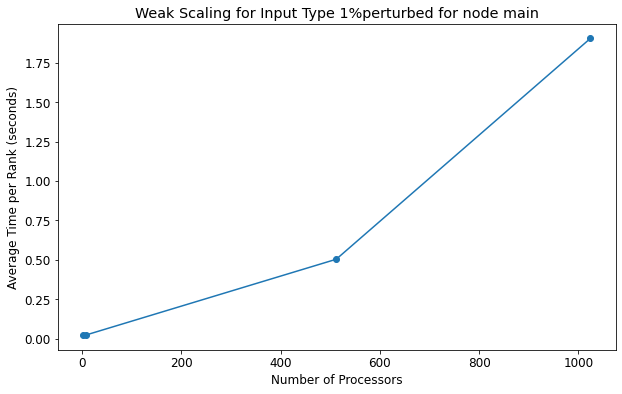

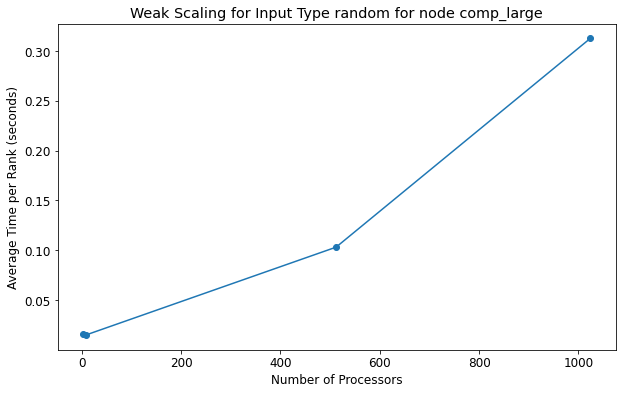

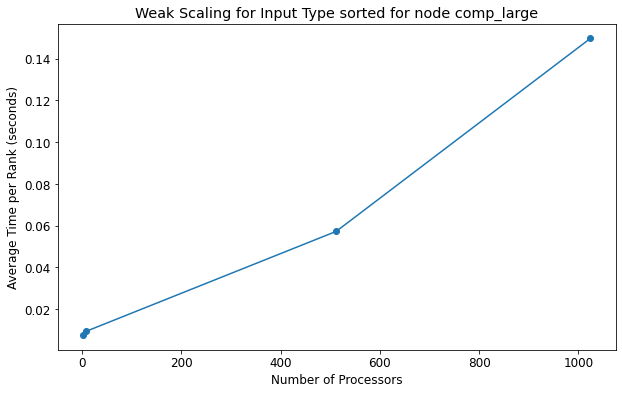

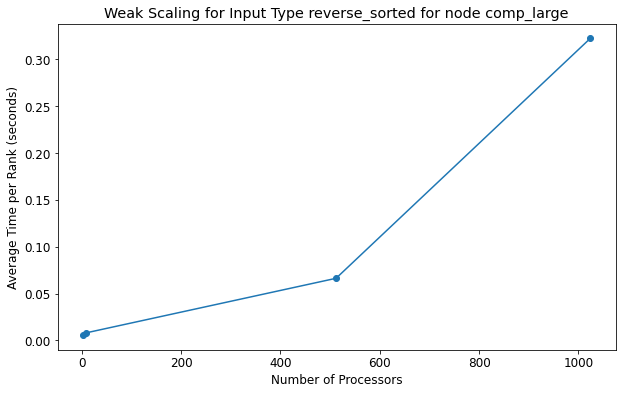

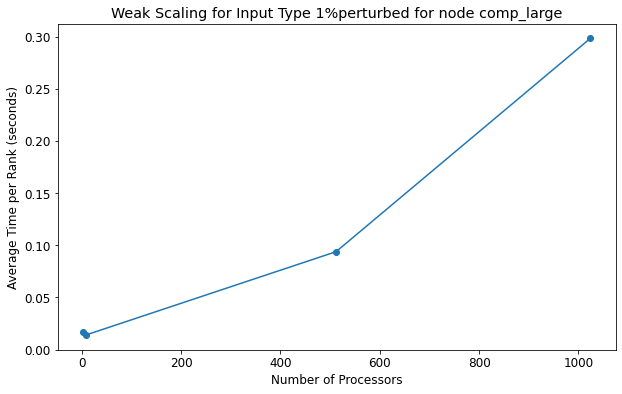

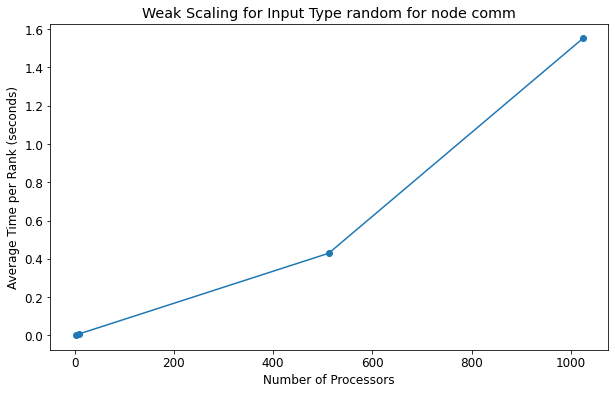

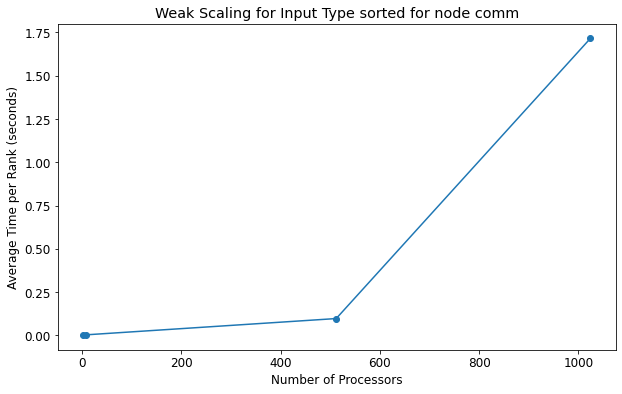

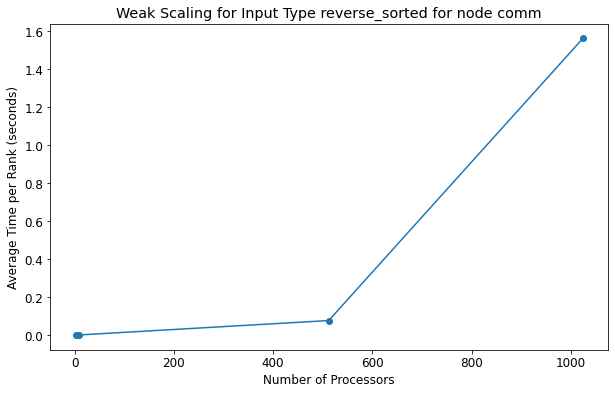

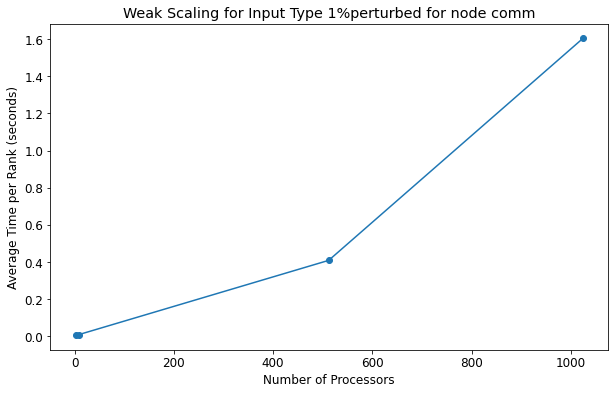

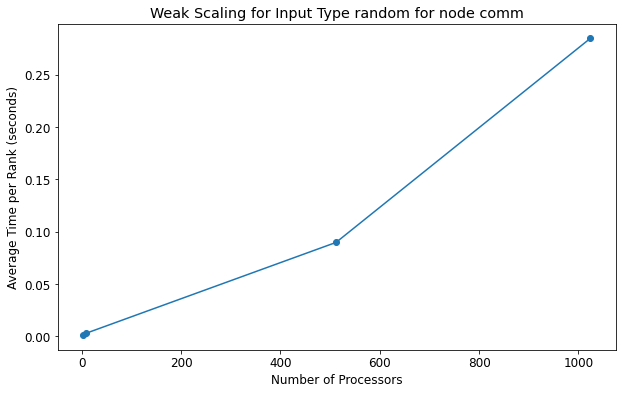

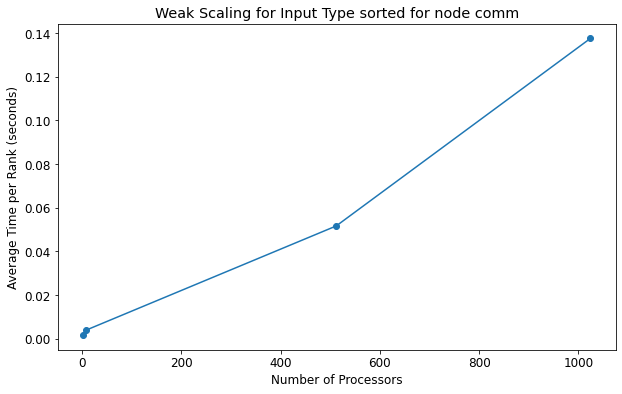

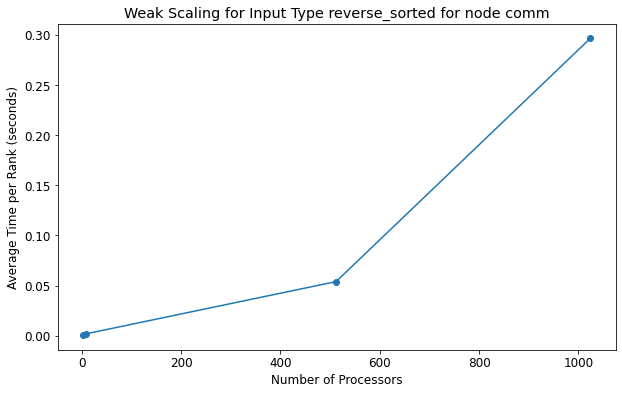

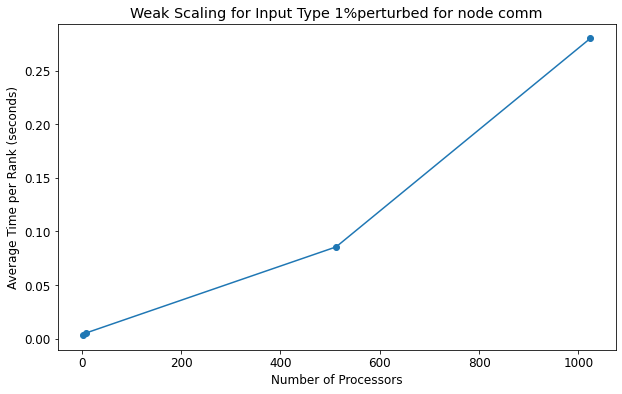

In [45]:
# weak scaling for each input type for main
plot_weak_scaling(tk, 'main')

# weak scaling for each input type for comp_large
plot_weak_scaling(tk, 'comp_large')

# weak scaling for each input type for comm
plot_weak_scaling(tk, 'comm')